# How LLMs Embeds Input Tokens?

In the initial phase of the input processing workflow, the input text is segmented into separate tokens using tiktoken library.

Following this [**read**](https://analyticalnikita.substack.com/p/sub-word-tokenization-using-byte), you can understand “how” and “why” tokens are transformed into token IDs based on a predefined vocabulary.

-----------------------------------------------------

Despite of having token ids we need token embeddings to capture the semantic relation between the tokens, to capture the meaning of the text and semantic similarity within them.

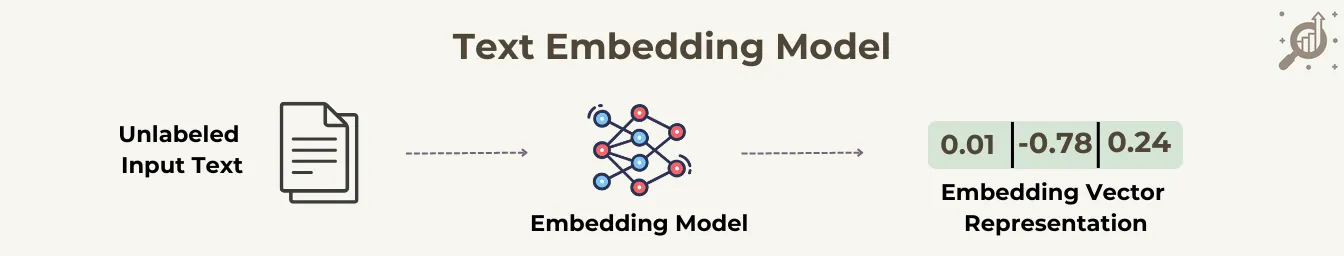

## Why Token Embeddings Are Important?

Token embeddings helps in creating the semantic relation between words/ tokens by creating vectors, which captures the relationship or closeness or difference between two words.

## Creating Input-Target Pairs

Let's first implement a data loader that fetches the input-target pairs using a sliding window approach.

To get started, we will first tokenize the whole The Awkening short story we worked with earlier using the BPE tokenizer introduced in the previous section

We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict.

This is an auto-regressive model because output of previous iteration becomes the part of the input of next iterations.

The LLMs prediction task during training is to predict the next-token that follows the input block.

During training, we mask out all the future tokens to avoid data leakage.



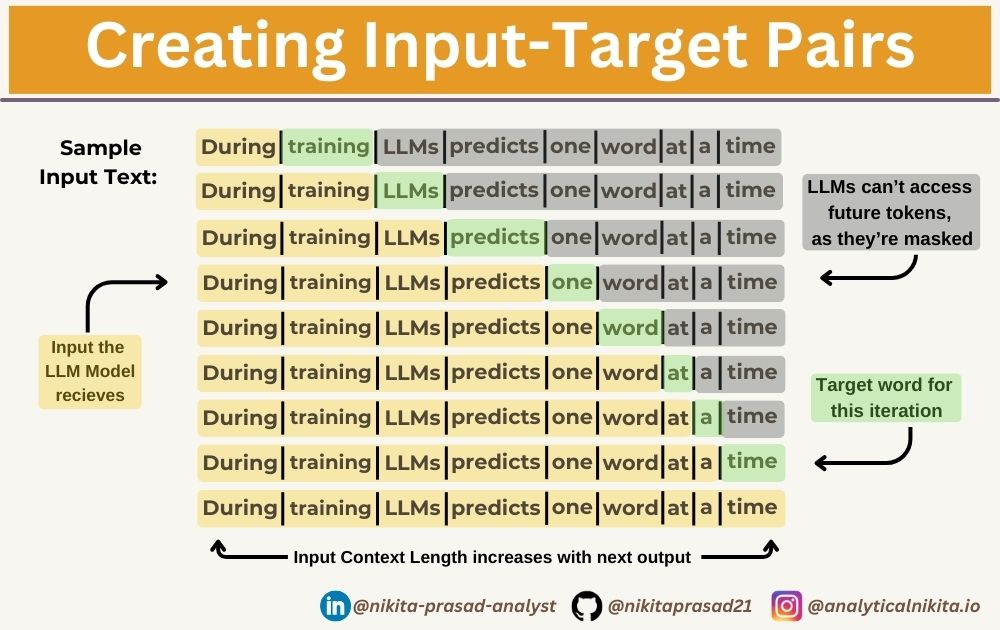

### Loading Dataset

In [ ]:
import os
import urllib.request

# URL of the raw content of the markdown file
if not os.path.exists("the-awkening.txt"):
    url = ("https://raw.githubusercontent.com/mlschmitt/classic-books-markdown/main/Kate%20Chopin/The%20Awakening.md")
    file_path = "the-awkening.txt"
    urllib.request.urlretrieve(url, file_path)

with open("the-awkening.txt", "r", encoding="utf-8") as f:
    input_text = f.read()

In [ ]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.5.1+cu121


In [ ]:
! pip3 install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.6 MB/s eta 0:00:00


In [ ]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.8.0


## Implementing a DataLoader

`dataloader` is an iterable that can iterate through the dataset as needed.

It fetches the input-target pairs using a sliding window approach, after creating the vocabulary using the [**Byte-Pair Encoding tokenizer**](https://github.com/nikitaprasad21/LLM-Cheat-Code/blob/main/Data-Preparation/Byte_Pair_Encoding.ipynb).

### Create `dataset` and `dataloader`

It extract chunks from the input text dataset.

One of the easiest and most intuitive ways to create the input-target pairs for the nextword prediction task is to create two variables, x and y, where x contains the input tokens and y contains the targets, which are the inputs shifted by 1:

For the efficient data loader implementation, we will use PyTorch's built-in `Dataset` and `DataLoader` classes.

**Step 1**: Tokenize the entire text

**Step 2**: Use a sliding window to chunk the book into overlapping sequences of `max_length`

**Step 3**: Return the total number of rows in the dataset

**Step 4**: Return a single row from the dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, input_text, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(input_text, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [ ]:
def dataloader(input_text, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(input_text, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

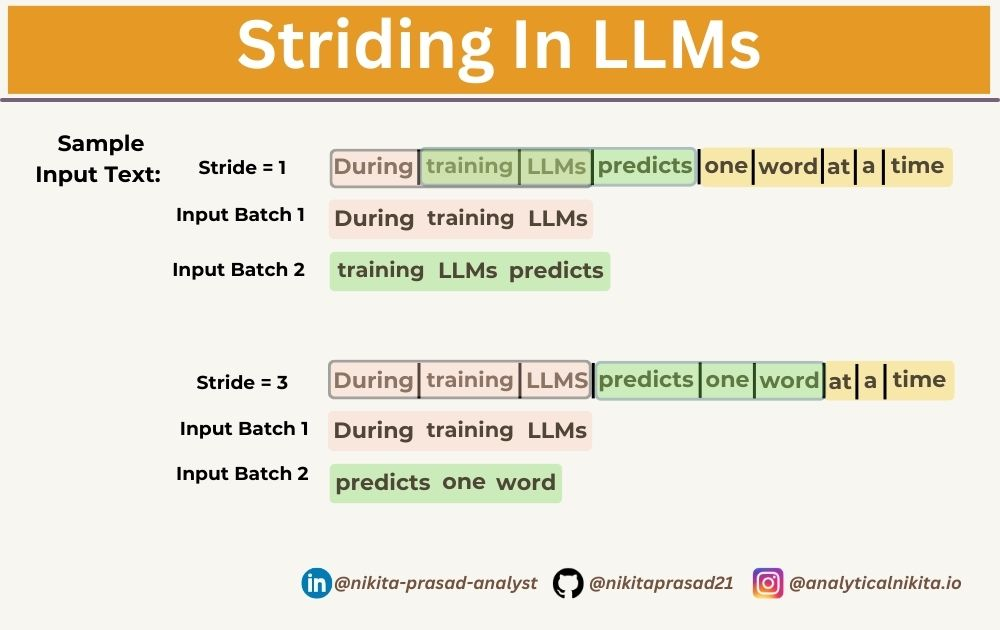

In [ ]:
# Stride = 1
dataloader = dataloader(
    input_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[    2, 11851,    25,   383]]), tensor([[11851,    25,   383, 28832]])]


In [ ]:
# Stride = 4
dataloader = dataloader(input_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[    2, 11851,    25,   383],
        [28832,   198,   198,  2235],
        [ 6434,    25, 16693, 40159],
        [  259,   198,   198,  2235],
        [ 6280,    25, 47465,   198],
        [  198, 26866,   198,   198],
        [ 2235,   220,   314,   198],
        [  198,    32,  4077,   290]])

Targets:
 tensor([[11851,    25,   383, 28832],
        [  198,   198,  2235,  6434],
        [   25, 16693, 40159,   259],
        [  198,   198,  2235,  6280],
        [   25, 47465,   198,   198],
        [26866,   198,   198,  2235],
        [  220,   314,   198,   198],
        [   32,  4077,   290,  7872]])


## Creating Token Embedding
* The data is already almost ready for an LLM
* But lastly let us embed the tokens in a continuous vector representation using an embedding layer
* Usually, these embedding layers are part of the LLM itself and are updated (trained) during model training

Suppose we have the following four input examples with input ids 5, 3, 7, and 2 (after tokenization):

In [ ]:
input_ids = torch.tensor([5, 3, 7, 2])

For the sake of simplicity, suppose we have a small vocabulary of only 9 words and we want to create embeddings of size 3:

In [ ]:
vocab_size = 9
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

This would result in a 9x3 weight matrix:

In [ ]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.3035],
        [-0.5880,  0.3486,  0.6603],
        [-0.2196, -0.3792,  0.7671],
        [-1.1925,  0.6984, -1.8061],
        [ 1.8960, -0.1750,  1.3689],
        [-1.6033, -1.3250,  0.1784],
        [-2.1338,  0.7953,  0.9985],
        [ 0.2212,  1.8319, -0.3378],
        [ 0.8805,  1.5542,  0.6266]], requires_grad=True)


If you're familiar with one-hot encoding, the embedding layer approach above is essentially just a more efficient way of implementing one-hot encoding followed by matrix multiplication in a fully-connected neural network layer that can be optimized via backpropagation.


To convert a token with id 3 into a 3-dimensional vector, we do the following:

In [ ]:
print(embedding_layer(torch.tensor([3])))

tensor([[-1.1925,  0.6984, -1.8061]], grad_fn=<EmbeddingBackward0>)



**Note**: The above is the only the 4th row in the embedding_layer weight matrix. So, to embed all four input_ids values above, we do:

In [ ]:
print(embedding_layer(input_ids))

tensor([[-1.6033, -1.3250,  0.1784],
        [-1.1925,  0.6984, -1.8061],
        [ 0.2212,  1.8319, -0.3378],
        [-0.2196, -0.3792,  0.7671]], grad_fn=<EmbeddingBackward0>)


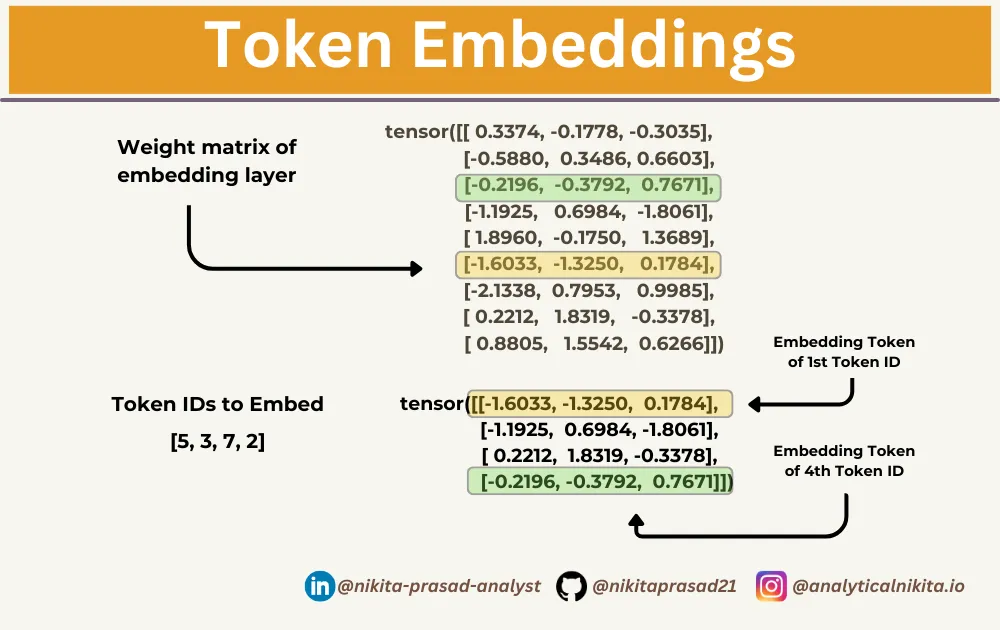

An embedding layer is essentially a look-up operation:


## Encoding Word Positions


Embedding layer convert IDs into identical vector representations regardless of where they are located in the input sequence:

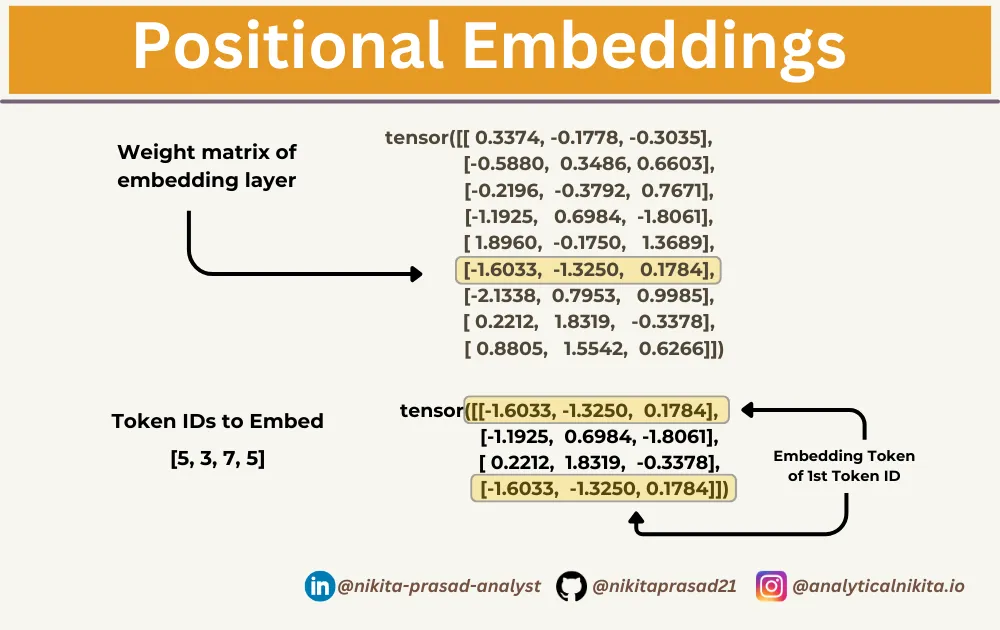

Positional embeddings are combined with the token embedding vector to form the input embeddings for a large language model.

For, GPT-2 (Small), the vector dimension is 768 and vocabulary size is 50257.

* The BytePair encoder has a vocabulary size of 50,257:
* Suppose we want to encode the input tokens into a 256-dimensional vector representation:

In [ ]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

* If we sample data from the dataloader, we embed the tokens in each batch into a 256-dimensional vector
* If we have a batch size of 8 with 3 tokens each, this results in a 8 x 3 x 256 tensor:

In [ ]:
max_length = 3
dataloader = dataloader(
    input_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [ ]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[    2, 11851,    25],
        [  383, 28832,   198],
        [  198,  2235,  6434],
        [   25, 16693, 40159],
        [  259,   198,   198],
        [ 2235,  6280,    25],
        [47465,   198,   198],
        [26866,   198,   198]])

Inputs shape:
 torch.Size([8, 3])


In [ ]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 3, 256])


GPT-2 uses absolute position embeddings, so we just create another embedding layer:


In [ ]:
context_length = max_length
positional_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [ ]:
pos_embeddings = positional_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([3, 256])


To create the input embeddings used in an LLM, we simply add the token and the positional embeddings:

In [ ]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 3, 256])


### Putting It All Together


LLMs Data Preprocessing Pipeline is consists of 4 Major Steps:

* **Tokenization**: Splitting input text in list of tokens (vocabulary)

* **Token Embeddings**: Converting token IDs to vector embeddings

* **Positional Embeddings**: Encoding positional information of each vector

* **Input Embeddings**: It is the addition of Token and Positional Embeddings

Input Embeddings are feed to the LLM transformer.





> Stay tuned, as next we’ll dive into Attention Mechanism of GPT-2. Don't forget to Star this Github Repository for more such contents and consider sharing with others.

